# Use this notebook to visualize graph exttration from a image

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import heapq
from fuel import GraphAdjacencyMatrixExtractor

def visualize_results(extractor, image_path, adjacency_matrix, labels):
    """
    Visualize the detected graph structure overlaid on the original image
    """
    # Load original image
    image = cv2.imread(image_path)
    vis_image = image.copy()

    # Detect nodes again
    nodes = extractor.detect_nodes(image)

    # Reorder adjacency matrix by labels for visualization
    ordered_matrix, ordered_labels = extractor.order_adjacency_matrix(adjacency_matrix, labels)

    # Create a mapping from ordered labels back to original indices for drawing
    label_to_orig_idx = {labels[i]: i for i in range(len(labels))}

    # Draw nodes
    for i, (x, y, r) in enumerate(nodes):
        cv2.circle(vis_image, (int(x), int(y)), int(r), (0, 255, 0), 2)
        cv2.putText(
            vis_image,
            str(labels[i]),
            (int(x-r/2), int(y+r/2)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 0, 255),
            2
        )

    # Draw edges according to original adjacency matrix (for visualization on image)
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adjacency_matrix[i, j] == 1:
                # Draw arrow from node i to node j
                start_x, start_y, _ = nodes[i]
                end_x, end_y, _ = nodes[j]

                # Calculate vector for the arrow
                dx = end_x - start_x
                dy = end_y - start_y
                length = np.sqrt(dx*dx + dy*dy)

                if length == 0:
                    continue

                # Normalize and scale to not overlap with nodes
                dx /= length
                dy /= length

                # Start and end points adjusted to not overlap with nodes
                start_point = (int(start_x + dx * nodes[i][2]), int(start_y + dy * nodes[i][2]))
                end_point = (int(end_x - dx * nodes[j][2]), int(end_y - dy * nodes[j][2]))

                # Draw the arrow
                cv2.arrowedLine(
                    vis_image,
                    start_point,
                    end_point,
                    (255, 0, 0),
                    2,
                    tipLength=0.3
                )

    # Display the resulting adjacency matrix with matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Graph Structure")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(ordered_matrix, cmap='Blues')
    plt.title("Ordered Adjacency Matrix")
    plt.xticks(range(len(ordered_labels)), ordered_labels)
    plt.yticks(range(len(ordered_labels)), ordered_labels)

    for i in range(len(ordered_labels)):
        for j in range(len(ordered_labels)):
            plt.text(j, i, str(ordered_matrix[i, j]),
                   ha="center", va="center", color="white" if ordered_matrix[i, j] > 0.5 else "black")

    plt.tight_layout()
    plt.savefig("graph_result.png")
    plt.show()

    # Also show the adjacency matrix using OpenCV (as an image)
    adj_img = (ordered_matrix * 255).astype(np.uint8)
    adj_img_color = cv2.cvtColor(adj_img, cv2.COLOR_GRAY2BGR)
    adj_img_color = cv2.resize(adj_img_color, (300, 300), interpolation=cv2.INTER_NEAREST)
    cv2.imshow("Ordered Adjacency Matrix", adj_img_color)
    cv2.imshow("Detected Graph Structure", vis_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return vis_image


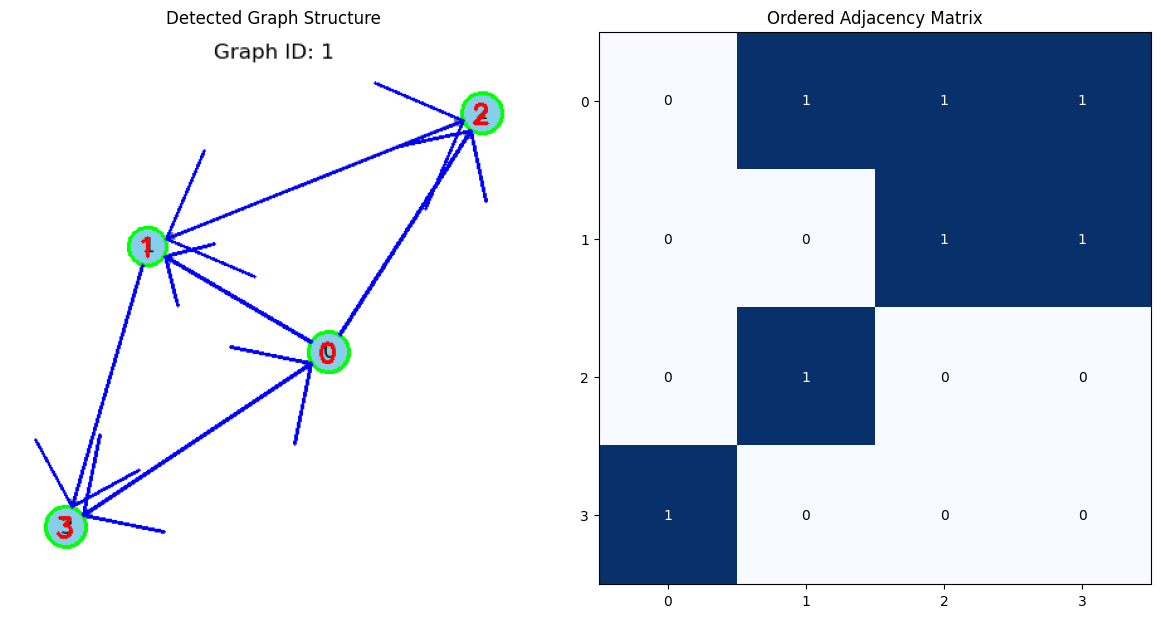

In [5]:
def main(image_path, start_label=0, end_label=None):
    """
    Process a graph image and extract its adjacency matrix,
    then solve the Operation Final Front++ problem
    """
    extractor = GraphAdjacencyMatrixExtractor()

    try:
        # Extract adjacency matrix
        adjacency_matrix, labels = extractor.extract_adjacency_matrix(image_path)

        # Get ordered matrix for visualization
        ordered_matrix, ordered_labels = extractor.order_adjacency_matrix(adjacency_matrix, labels)

        # If labels are not integers, convert them to indices
        label_to_idx = {label: i for i, label in enumerate(labels)}

        # If we found a node labeled specifically as the start_label
        if start_label in labels:
            start_idx = labels.index(start_label)
        else:
            # Otherwise default to the first node
            start_idx = 0

        # If end_label is not specified, use the highest numbered node as target
        if end_label is None:
            numeric_labels = [label for label in labels if isinstance(label, int)]
            end_label = max(numeric_labels) if numeric_labels else len(labels) - 1

        # If we found a node labeled specifically as the end_label
        if end_label in labels:
            end_idx = labels.index(end_label)
        else:
            # Otherwise default to the last node
            end_idx = len(labels) - 1
        # Visualize results (now uses ordered matrix)
        vis_image = visualize_results(extractor,image_path, adjacency_matrix, labels)

        return adjacency_matrix, labels, ordered_matrix, ordered_labels

    except Exception as e:
        print(f"Error: {e}")
        return None, None, -1, None, None

if __name__ == "__main__":
    main("graphs_images/1.png")
